# Tree Genereration

## Input Selection

In [1]:
import ipywidgets as widgets
import os
from IPython.display import clear_output

input_examples_words_mapping = {
    'Cities': ['City','Berlin','London','Tokyo','Paris','Singapore','Amsterdam','Seoul'],
    'Fruits': ['Fruit','Orange','Banana'],
    'Small': ['church', 'kirk', 'cathedral'],
    'Medium': ['car','house','toy','fruit','banana'],
    'Large': ['Akee','Apple','Apricot','Kiwifruit','Kumquat','Lime','Loquat','Pineapple','Tayberry','Plumcot','Lychee','Damson','Cucumber','Cloudberry','Banana','Fig','Jambul','Mango','Orange','Clementine','Papaya','Peach','Salal','Satsuma'],
    'Custom' : []
}

INPUT = None

DATA_FOLDER_PATH = 'visualization'

# UI Widgets
input_examples = widgets.Combobox(
    placeholder='Choose Example',
    options=list(input_examples_words_mapping.keys()),
    description='Input:'
)
check_cutom_input_button = widgets.Button(
    description='Check',
    button_style='success',
    tooltip='Click here to check the input',
)
words_input = widgets.Textarea(
    value='',
    placeholder='keywords comma separated',
    description='Words'
)

# Helper Functions
def log_input(input_name, input_value):
    clear_output()
    print('Example %s contains the following words: %s'%(input_name, input_value))

# UI Widget functions
def on_input_example_choose(change):
    global INPUT
    if change['type'] == 'change' and change['name'] == 'value':
        choosen_values = change['new']
        if (choosen_values == 'Custom'):
            display(words_input)
            display(check_cutom_input_button)
        else:
            log_input(choosen_values, input_examples_words_mapping[choosen_values])
            INPUT = input_examples_words_mapping[choosen_values]

def on_generate_tree_button_clicked(button):
    global INPUT
    parsed_tokens = [x.strip() for x in str(words_input.value).split(',')]
    words = [x for x in parsed_tokens if x]
    if len(words) > 0:
        INPUT = words
        log_input('Custom', words)
    else:
        print("Can't parse your input! Try Again!")

# Set Widget listeners
input_examples.observe(on_input_example_choose)
check_cutom_input_button.on_click(on_generate_tree_button_clicked)

# Start UI nteraction
display(input_examples)

Example Cities contains the following words: ['City', 'Berlin', 'London', 'Tokyo', 'Paris', 'Singapore', 'Amsterdam', 'Seoul']


## Generate Tree Files

In [2]:
from nltk.corpus import wordnet as wn
from collections import defaultdict
import os

WORDS_PATHS = None
CHILDREN = None

DATA_FOLDER_PATH = '.\data_in'
CHILDREN_FILE_PATH  = DATA_FOLDER_PATH + '\children.txt'
WORDS_PATHS_FILE_PATH = DATA_FOLDER_PATH + '\wordspaths.txt'
CAT_CODE_FILE_PATH = DATA_FOLDER_PATH + "\catcode.txt"

def save_data(file_path, lines):
    with open(file_path, 'w') as file:
        for line in lines:
            file.write(line)
            if not '\n' in line:
                file.write("\n")

def generate_words_paths(words, glove_words_set):
    all_words_paths = []
    all_words_paths.append("*root* *root*\n")
    word_paths = {}
    for word in words:
        if word.lower() not in glove_words_set:
            continue
        synsets = wn.synsets(word)
        for synset in synsets:
            generare_hypernym_path(synset, word_paths, glove_words_set)
    for value in word_paths.values():
        all_words_paths.append(value + "\n")
    return all_words_paths
        
def generate_path(synset, glove_words_set):
    word_path = synset.name() + " *root* "
    hypernym_path_synsets = synset.hypernym_paths()[0]
    for hypernym_path_synset in hypernym_path_synsets:
        word = hypernym_path_synset.name()
        if "_" not in word and "-" not in word and word.split('.')[0] in glove_words_set:
            word_path += hypernym_path_synset.name() + " "
    return word_path

def generare_hypernym_path(synset, words_paths, glove_words_set):
    if synset is None:
        return
    if "_" in synset.name() and "-" in synset.name():
        return
    if synset.name() in words_paths:
        return
    synset_path = generate_path(synset, glove_words_set)
    words_paths[synset.name()] = synset_path
    hypernym_path_synsets = synset.hypernym_paths()[0]
    for hypernym_path_synset in hypernym_path_synsets:
        word = hypernym_path_synset.name()
        if "_" not in word and "-" not in word and word.split('.')[0] in glove_words_set:
            generare_hypernym_path(hypernym_path_synset, words_paths, glove_words_set)
            
def generate_child(words_paths):
    child_dic = {}
    has_child = set()
    all_words = set()
    for word_path_line in words_paths:
        word = word_path_line.strip().split()[0]
        child_dic[word] = set()
    for word_path_line in words_paths:
        path_tokens = word_path_line.strip().split()[1:]
        for i,token in enumerate(path_tokens):
            if i < len(path_tokens)-1:
                child_dic[path_tokens[i]].add(path_tokens[i+1])
    output = []
    for key,value in child_dic.items():
        output_line = key + " "
        for value in list(value):
            output_line+= value + " "
        output.append(output_line[:-1] + "\n")
    return output


def generate_ws_cat_codes(cpathFile = "", childrenFile ="",  outFile="", depth=0):
    wsPathDic, wsChildrenDic = defaultdict(), defaultdict()
    with open(cpathFile, 'r') as cfh:
        for ln in cfh.readlines():
            lst = ln[:-1].split()
            wsPathDic[lst[0]] = lst[1:]
    with open(childrenFile, 'r') as chfh:
        for ln in chfh.readlines():
            lst = ln.strip().split()
            if len(lst) == 0:
                continue
            if len(lst) == 1:
                wsChildrenDic[lst[0]] = []
            else:
                wsChildrenDic[lst[0]] = lst[1:]
    ofh = open(outFile, 'w')
    ml, nm = 0, ''
    for node, plst in wsPathDic.items():
        plst = plst[:-1]
        clst = ["1"]
        if ml < len(plst):
            ml = len(plst)
            nm = node
        for (parent, child) in zip(plst[:-1], plst[1:]):
            if parent in wsChildrenDic:
                children = wsChildrenDic[parent]
            if child in children:
                clst.append(str(children.index(child) +1))
        clst += ['0'] * (depth - len(clst))
        line = " ".join([node] + clst) + "\n"
        ofh.write(line)
    ofh.close()
    return nm, ml

def read_glove_file(glove_file_path):
    glove_words_set = set()
    with open(glove_file_path, mode="r", encoding="utf-8") as file:
        for line in file:
            glove_words_set.add(line[:-1].split()[0])
    return glove_words_set

# UI Widgets
show_output = widgets.Button(
    description='Print result',
    button_style='success',
    tooltip='Click here to print the result',
)
hide_output = widgets.Button(
    description='Clear result',
    button_style='danger',
    tooltip='Click here to clear the result',
)
buttons_box = widgets.Box([show_output,hide_output])

# UI Widgets
glove_path_input = widgets.Text(
    placeholder='glove full path',
    value = "C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/glove.txt",
    description='Glove'
)
display(glove_path_input)

# Helper Functions
def no_input_handler():
    print("No input! Please run input cell")
    
def print_words_paths(word_paths):
    print("-------------------------------Words Paths--------------------")
    for word_path in word_paths:
        print(word_path)

def print_words_paths_summery(words_paths):
    print('%s words paths found'%(len(words_paths)))
    
def print_children(children):
    print("------------------------------Children-----------------------")
    for child in children:
        print(child)
    
def print_children_summery(children):
    sub_tree_count = 0
    leaves_count = 0
    for line in children:
        tokens = line.split(" ")
        if len(tokens) > 1:
            sub_tree_count = sub_tree_count + 1
        else:
            leaves_count = leaves_count + 1
    print('%s Leaves found'%(leaves_count))
    print('%s Subtree found'%(sub_tree_count - 1))
    
def create_data_folder(path):
    try:
        os.mkdir(path)
    except OSError:
        pass
    
# UI Widget functions
def on_show_output_button_clicked(button):
    global WORDS_PATHS
    print_words_paths(WORDS_PATHS)
    print_children(CHILDREN)
    
def on_hide_output_button_clicked(button):
    global WORDS_PATHS
    if not WORDS_PATHS is None:
        clear_output()
        print_words_paths_summery(WORDS_PATHS)
        print_children_summery(CHILDREN)
        display(buttons_box)
        
# Set Widget listeners
show_output.on_click(on_show_output_button_clicked)
hide_output.on_click(on_hide_output_button_clicked)

# Start UI Interaction
def start():
    try:
        INPUT
    except NameError:
        no_input_handler()
    else:
        if not INPUT is None and glove_path_input.value:
            glove_words_set = read_glove_file(glove_path_input.value)
            words_paths = generate_words_paths(INPUT,glove_words_set)
            if len(words_paths) <= 0:
                print('No words paths found! Try Again!')
            else:
                WORDS_PATHS = words_paths
                CHILDREN = generate_child(WORDS_PATHS)
                print_words_paths_summery(words_paths)
                print_children_summery(CHILDREN)
                display(buttons_box)
                create_data_folder(DATA_FOLDER_PATH)
                save_data(CHILDREN_FILE_PATH ,CHILDREN)
                save_data(WORDS_PATHS_FILE_PATH , WORDS_PATHS)

                generate_ws_cat_codes(WORDS_PATHS_FILE_PATH, CHILDREN_FILE_PATH, CAT_CODE_FILE_PATH, depth=15)
        else:
            no_input_handler()
start()

Text(value='C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/glove.txt', description='Glove', placeholde…

56 words paths found
18 Leaves found
37 Subtree found


Box(children=(Button(button_style='success', description='Print result', style=ButtonStyle(), tooltip='Click h…

-------------------------------Words Paths--------------------


TypeError: 'NoneType' object is not iterable

## Generate Nballs

In [5]:
import ipywidgets as widgets
from IPython.display import clear_output
import os, shutil

def generate_nballs(glove_file_path, project_path, output_path, children_file_path,cat_code_file_path):
    outputPath, nballFile = os.path.split(output_path)
    if os.path.exists("%s/data_out"%(outputPath)):
        shutil.rmtree("%s/data_out"%(outputPath))
    generate_balls_string_command = "%s/nball.py --train_nball %s --w2v %s --ws_child %s --ws_catcode %s --log %s/log.txt"
    command = generate_balls_string_command%(project_path, output_path, glove_file_path, children_file_path, cat_code_file_path,outputPath)     
    %run $command

# Helper Functions
def no_input_handler():
    print("No data folder has been created! Try again!")
    
# UI Widgets
glove_path_input = widgets.Text(
    placeholder='glove full path',
    value = "C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/glove.txt",
    description='Glove'
)
nball4tree_project_path_input = widgets.Text(
    placeholder='nball4tree full path',
    value = "C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree",
    description='nball4tree'
)
children_path_input = widgets.Text(
    placeholder='children inut path',
    value = "C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/small.children.txt",
    description='Children'
)
catcode_path_input = widgets.Text(
    placeholder='catcode inut path',
    value = "C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/small.catcode.txt",
    description='CatCode'
)
output_path_input = widgets.Text(
    placeholder='output path',
    value = "test",
    description='Output'
)
generate_balls = widgets.Button(
    description='Generate Nball',
    button_style='success',
    tooltip='Click here to generate nballs',
)
clear_button_click = widgets.Button(
    description='Clear result',
    button_style='danger',
    tooltip='Click here to clear the result',
)
buttons_box = widgets.Box([generate_balls,clear_button_click])

# UI Widget functions
def on_generate_balls_button_clicked(button):
    glove_file_path = glove_path_input.value
    project_folder_path = nball4tree_project_path_input.value
    try:
        DATA_FOLDER_PATH
        output_path = os.getcwd() + "/" + DATA_FOLDER_PATH + "/nball.txt"
        print("Generating balls! Please Wait...!")
        generate_nballs(glove_file_path, project_folder_path, output_path, CHILDREN_FILE_PATH, CAT_CODE_FILE_PATH)
    except NameError:
        output_path = output_path_input.value
        children_file_path = children_path_input.value
        catcode_file_path = catcode_path_input.value
        generate_nballs(glove_file_path, project_folder_path, output_path, children_file_path, catcode_file_path)
    
def on_clear_button_clicked(button):
    clear_output()
    start()

# Set Widget listeners
generate_balls.on_click(on_generate_balls_button_clicked)
clear_button_click.on_click(on_clear_button_clicked)

# Start UI Interaction
def start():
    try:
        DATA_FOLDER_PATH
        display(glove_path_input)
        display(nball4tree_project_path_input)
        display(buttons_box)
    except NameError:
        display(glove_path_input)
        display(nball4tree_project_path_input)
        display(output_path_input)
        display(catcode_path_input)
        display(children_path_input)
        display(buttons_box) 
start()

Text(value='C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree/data/subset/glove.txt', description='Glove', placeholde…

Text(value='C:/Users/Mhd-Ghanem/Desktop/Lab/nball4tree', description='nball4tree', placeholder='nball4tree ful…

Box(children=(Button(button_style='success', description='Generate Nball', style=ButtonStyle(), tooltip='Click…

Generating balls! Please Wait...!
['entity.n.01']
*** entity.n.01
finished training of all families

loading balls....
[167]
totally 55  balls are loaded
updating first level children...
checking whether the tree structure is perfectly encoded in nball embeddings...

loading balls....
[167]
totally 55  balls are loaded
failed families with P []
failed families with DC []
the tree structure is perfectly encoded in nball embeddings.

generating nball embedding file...



## Visualizing NBall 

Box(children=(Button(button_style='success', description='Select All', style=ButtonStyle()), Button(button_sty…

GridBox(children=(Checkbox(value=True, description='ability.n.02'), Checkbox(value=True, description='abstract…

<IPython.core.display.Javascript object>


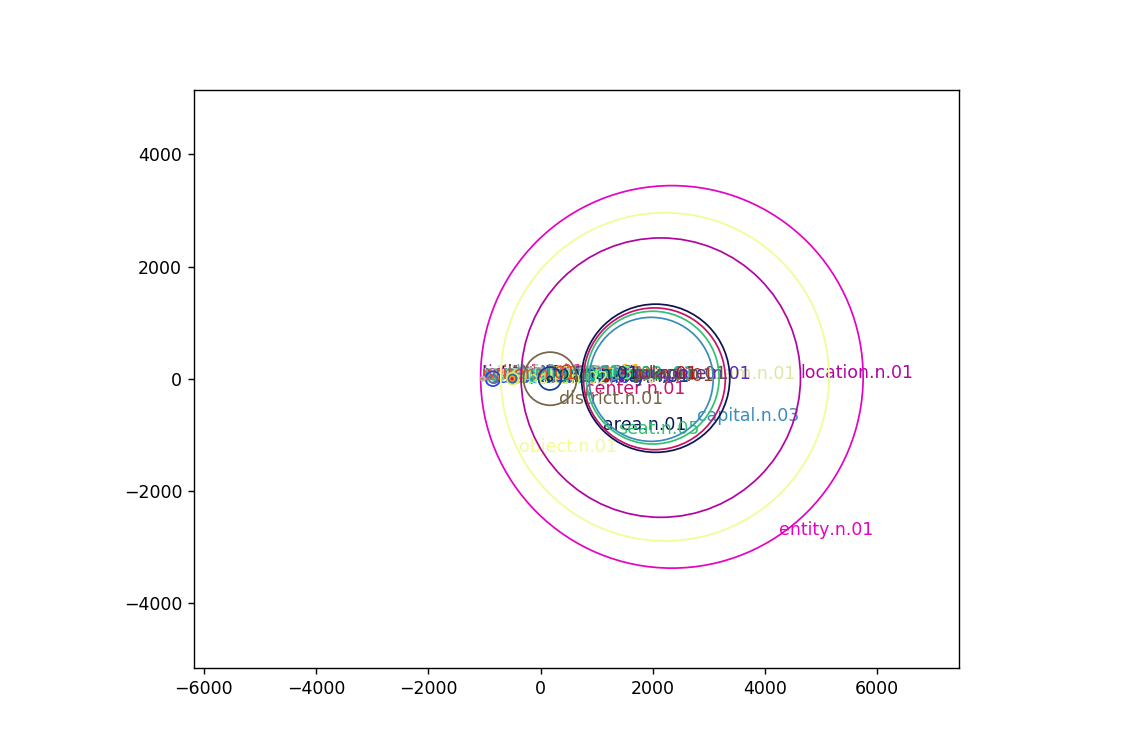

In [7]:
%matplotlib notebook
from matplotlib import pyplot
from matplotlib.patches import Circle
import matplotlib.animation as animation

import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np
import random

from sklearn.decomposition import PCA
from decimal import *
from math import pi, cos, sin

recuded_vectors = []
words = []
radius = []

def random_point(xy, r):
    r = float(r)
    theta = random.random() * 2 * pi
    return xy[0] + cos(theta) * r, xy[1] + sin(theta) * r

def circle(xy, radius, color="lightsteelblue", facecolor="none", alpha=1, ax=None):
    e = Circle(xy=xy, radius=float(radius))
    ax.add_artist(e)
    e.set_edgecolor(color)
    e.set_facecolor(facecolor)
    e.set_alpha(alpha)
    
ax = None
fig = None

# UI Widgets
nball_path_input = widgets.Text(
    placeholder='nballs full path',
    value = "C:/Users/Mhd-Ghanem/visualization/nball.txt",
    description='Nball'
)
visualize_balls = widgets.Button(
    description='Visualize Nball',
    button_style='success',
    tooltip='Click here to Visualize nballs',
)
clear_button_click = widgets.Button(
    description='Clear result',
    button_style='danger',
    tooltip='Click here to clear the result',
)
select_all_button = widgets.Button(
    description='Select All',
    button_style='success',
)
unselect_all_button = widgets.Button(
    description='Unselect All',
    button_style='danger'
)
nball_input_buttons_box = widgets.Box([visualize_balls,clear_button_click])
select_unselect_all_buttons_box = widgets.Box([select_all_button,unselect_all_button])


def new_decimal(value):
    return Decimal(value) * Decimal(1.0)

def to_decimal_np_array(tokens):
    decimal_array = []
    for token in tokens:
        decimal_array.append(new_decimal(token))
    return np.array(decimal_array)

def parse_ball_data(line):
    tokens = line.rstrip('\n').split(' ')
    ball = {}
    ball['word'] = tokens[0]
    ball['vector'] = to_decimal_np_array(tokens[1:len(tokens) - 2])
    ball['length'] = new_decimal(tokens[len(tokens) - 2:len(tokens) - 1][0])
    ball['vector'] = np.multiply(ball['vector'], ball['length'])
    ball['radius'] = new_decimal(tokens[len(tokens) - 1:len(tokens)][0])
    return ball['word'],ball

def read_and_parse_balls_file(balls_file_path, number_of_balls = -1):
    with open(balls_file_path) as myfile:
        if number_of_balls == -1:
            lines = myfile.readlines()
        else:
            lines = [next(myfile) for x in range(number_of_balls)]
    balls = {}
    for line in lines:
        word,ball = parse_ball_data(line)
        balls[word] = ball
    return balls

def get_arrays_from_balls(balls, blocked_words = [], allowed_words = [], is_block = True):
    vectors = []
    words = []
    radius = []
    length = []
    for ball in balls.values():
        if is_block:
            if ball['word'] in blocked_words:
                continue
        else:
            if not ball['word'] in allowed_words:
                continue
        words.append(ball['word'])
        vectors.append(ball['vector'])
        radius.append(ball['radius'])
        length.append(ball['length'])
    return vectors, words, radius, length


def reduce_dimensions(vectors, dimenstion = 2):
    vectors = np.array(vectors)
    if dimenstion == 3:
        n_components = 3
    else:
        n_components = 2
    pca = PCA(n_components)
    return pca.fit_transform(vectors)

def plot(vectors, radiuses, words, shown_words):
    global ax
    global fig
    filtered_vectors = []
    filtered_words = []
    filtered_radius = []
    for i,vector in enumerate(vectors):
        if words[i] in shown_words:
            filtered_vectors.append(vector)
            filtered_radius.append(radiuses[i])
            filtered_words.append(words[i])
    vectors = filtered_vectors
    words = filtered_words
    radiuses = filtered_radius
    if len(vectors) == 0 or len(words) == 0 or len(radiuses) == 0:
        pyplot.cla()
        return ""
    colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(vectors))]
    vectors = np.array(vectors)
    for i, vector in enumerate(vectors):
        circle(xy=vector,
               radius=radiuses[i], ax=ax,
               color=colors[i])
    x = [i[0] for i in vectors]
    y = [i[1] for i in vectors]
    margin = 1.5 * int(max(radiuses))
    minX = min(x) - margin
    maxX = max(x) + margin
    minY = min(y) - margin
    maxY = max(y) + margin
    ax.set_xlim([minX, maxX])
    ax.set_ylim([minY, maxY])
    for i, word in enumerate(words):
        point = random_point(vectors[i], radiuses[i])
        ax.text(point[0], point[1], '%s' % (str(word)), size=10, zorder=1, color=colors[i])
    pyplot.show()

checkbox_items = []
    
def create_checkbox_grid(words):
    global ax
    global fig
    global checkbox_items
    for word in words:
        checkbox_changed = widgets.Checkbox(value=True, description=word)
        checkbox_changed.observe(checkbox_changed_callback)
        checkbox_items.append(checkbox_changed)
    grid = widgets.GridBox(checkbox_items, layout=widgets.Layout(grid_template_columns="repeat(5, 150px)"))
    display(select_unselect_all_buttons_box)
    display(grid)
    fig, ax = pyplot.subplots()
    ax.set_aspect(1)
    fig.set_figheight(6)
    fig.set_figwidth(9)

def reduce_and_plot(nball_file_path):
    global recuded_vectors
    global words
    global radius
    balls = read_and_parse_balls_file(nball_file_path)
    vectors, words, radius, lengths = get_arrays_from_balls(balls, [], [], True)
    create_checkbox_grid(words)
    recuded_vectors = reduce_dimensions(vectors)
    plot(recuded_vectors, radius, words , set(words))

def update_plot():
    global recuded_vectors
    global words
    global radius
    pyplot.cla()
    showen_words = set()
    for checkbox in checkbox_items:
        if checkbox.value:
            showen_words.add(checkbox.description)
    plot(recuded_vectors,radius, words , showen_words)


def checkbox_changed_callback(b):
    if b['type'] == 'change' and b['name'] == 'value':
        update_plot()


# UI Widget functions
def on_visualize_balls_button_clicked(button):
    nball_file_path = nball_path_input.value
    reduce_and_plot(nball_file_path)
    nball_input_buttons_box.layout.visibility = 'hidden'
        
def on_clear_button_clicked(button):
    clear_output()
    start()

def on_select_all_button_clicked(button):
    for checkbox in checkbox_items:
        checkbox.unobserve_all()
        checkbox.value = True
        checkbox.observe(checkbox_changed_callback)
    update_plot()
    

def on_unselect_all_button_clicked(button):
    for checkbox in checkbox_items:
        checkbox.unobserve_all()
        checkbox.value = False
        checkbox.observe(checkbox_changed_callback)
    update_plot()
        
    
# Set Widget listeners
visualize_balls.on_click(on_visualize_balls_button_clicked)
clear_button_click.on_click(on_clear_button_clicked)
select_all_button.on_click(on_select_all_button_clicked)
unselect_all_button.on_click(on_unselect_all_button_clicked)

    
# Start UI Interaction
def start():
    try:
        DATA_FOLDER_PATH
        nball_file = os.getcwd() + "/" + DATA_FOLDER_PATH + "/nball.txt"
        reduce_and_plot(nball_file)
    except NameError:
        display(nball_path_input)
        display(nball_input_buttons_box)
start()